#### Useful Links

Useful Links:
- Why DETR predicts same bounding box for each image? https://github.com/facebookresearch/detr/issues/202

#### Connect Google Drive

To get access to the trained model.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Installing Necessary Libraries

Here we install all the necessary libraries required for Setting Up Vision Transformer with Relative Positional Encoding. We rely on an existing implementation of image RPE [here](https://github.com/microsoft/Cream/tree/main/iRPE/DETR-with-iRPE). I forked it to incorporate some minor changes.

In [2]:
%%capture
# iRPE
!git clone https://github.com/RishiDarkDevil/ViT-RPE.git # clone if already not cloned
%cd ViT-RPE/iRPE/DETR-with-iRPE
!pip install -r ./requirements.txt

# # iRPE for CUDA -- Comment  the below lines if you are not using CUDA
# %cd rpe_ops
# !python setup.py install --user
# %cd ..

### Import Libraries

In [3]:
# General
import requests
import argparse
import os
from io import BytesIO

# Matrix Manipulation
import numpy as np

# Plotting
import matplotlib.pyplot as plt

# COCO Data Handling
from pycocotools.coco import COCO
from pycocotools import mask as coco_mask
from datasets.coco import convert_coco_poly_to_mask
from datasets.coco import ConvertCocoPolysToMask
from util.misc import nested_tensor_from_tensor_list

# Model Output Processing
from models.detr import PostProcess

# Image Processing
import cv2
from PIL import Image
import datasets.transforms as T

# Model Building
import torch
from models import build_model
from models.backbone import build_backbone
from models.transformer import build_transformer
from models.detr import DETR
from models.segmentation import DETRsegm
from models.transformer import RPE_HELP
from torchvision.ops import nms

/content/ViT-RPE/iRPE/DETR-with-iRPE/models/rpe_attention/irpe.py:14: UserWarning: [WARNING] The module `rpe_ops` is not built. For better training performance, please build `rpe_ops`.
  warnings.warn(RED_STR.format("[WARNING] The module `rpe_ops` is not built. \


### Inference

Set some parameters below.

In [ ]:
DEVICE = 'cuda # set the device

#### Load Image

Load the image below for inference. If you are loading image from a dataset in `COCO` format then considering running the next section `Training Annotations (Optional)`

In [ ]:
# # To Load image from URL run the commented lines only 
# url = "https://i.natgeofe.com/n/548467d8-c5f1-4551-9f58-6817a8d2c45e/NationalGeographic_2572187_square.jpg"
# response = requests.get(url)
# init_img = Image.open(BytesIO(response.content)).convert("RGB")

# # To Load image from a path run the below lines only
init_img = Image.open('/content/drive/MyDrive/AIISC-Internship/text-based-object-discovery/Data-Generated/train/22_1.png').convert("RGB")
init_img

#### Training Annotations (Optional)

To view the annotations present for the above image (assuming you have a dataset adhering to `COCO` Format out of which the above image was taken) run this section. If you took an image right off from the internet/you don't have the annotations available, you don't need to run this section.

Set the `annotation_path`, `caption_path`, `image_dir` and `image_name` for the `COCO` dataset below.

In [4]:
annotation_path = r'/content/drive/MyDrive/AIISC-Internship/text-based-object-discovery/Data-Generated/annotations/train_annotations.json'
caption_path = r'/content/drive/MyDrive/AIISC-Internship/text-based-object-discovery/Data-Generated/captions/train_captions.json'
image_dir = r'/content/drive/MyDrive/AIISC-Internship/text-based-object-discovery/Data-Generated/train'
image_name = '101_0.png'

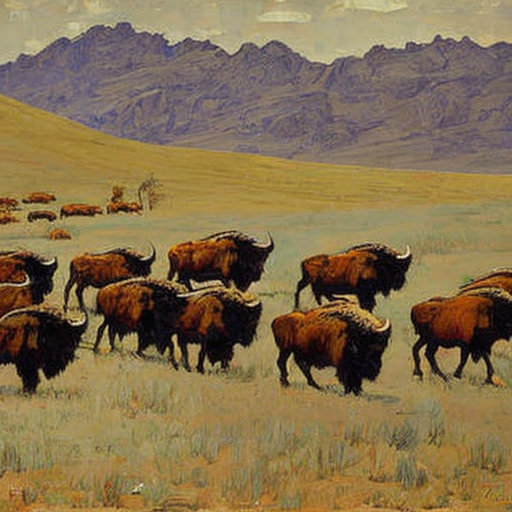

In [5]:
init_img = Image.open(os.path.join(image_dir, image_name)).convert("RGB")
init_img

In [6]:
init_img = Image.open(os.path.join(image_dir, image_name)).convert("RGB")
coco_annotation = COCO(annotation_file=annotation_path)
coco_caption = COCO(annotation_file=caption_path)

loading annotations into memory...
Done (t=8.68s)
creating index...
index created!
loading annotations into memory...
Done (t=0.59s)
creating index...
index created!


Below we visualize our synthetic annotated dataset. We now can exploit the benefit of using COCO dataset format, i.e. COCO utility functions for visualizing the results.

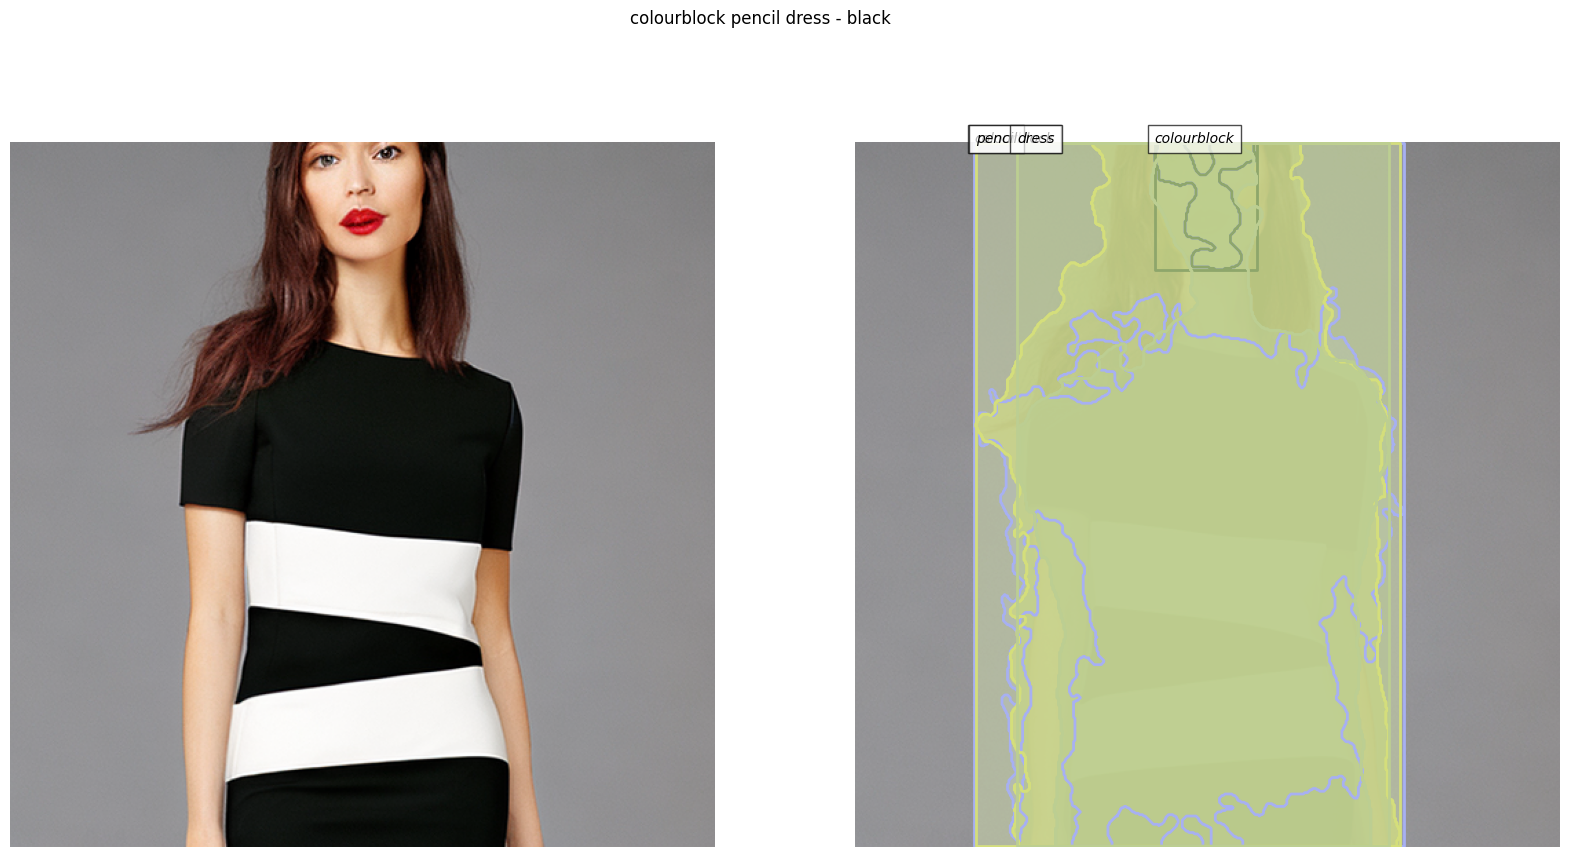

In [ ]:
# visualize_annotation(image_name)

In [7]:
for image in coco_annotation.dataset['images']:
  if image['file_name'] == image_name:
    image_id = image['id']
# Load Image Details corresponding to the image_id
img_info = coco_annotation.loadImgs([image_id])[0]
img_file_name = img_info['file_name']
# Load Annotation Details corresponding to the image_id
ann_ids = coco_annotation.getAnnIds(imgIds=[image_id], iscrowd=None)
cap_ids = coco_caption.getAnnIds(imgIds=[image_id])
anns = coco_annotation.loadAnns(ann_ids)
ann_names = [coco_annotation.loadCats(ann['category_id'])[0]['name'] for ann in anns]
cap = coco_caption.loadAnns(cap_ids)
# Load Image corresponding to the image_id
im = Image.open(os.path.join(image_dir, img_file_name))

In [43]:
def visualize_object_annotation(class_name, figsize = (20,10)):
  plt.rcParams['figure.figsize'] = (10,10)
  anns1 = [ann for ann in anns if coco_annotation.loadCats(ann['category_id'])[0]['name'] == class_name]
  ann_names1 = [name for name in ann_names if name == class_name]
  with out:
    clear_output(True)
    # Plot and visualize results
    plt.axis('off')
    plt.imshow(np.asarray(im))
    coco_annotation.showAnns(anns1, draw_bbox=True)
    for i, ann in enumerate(anns1):
      plt.text(anns1[i]['bbox'][0], anns1[i]['bbox'][1], ann_names1[i], style='italic', 
              bbox={'facecolor': 'white', 'alpha': 0.7, 'pad': 5})
    plt.suptitle(class_name)
    plt.show()
  plt.rcParams['figure.figsize'] = (8,6)

In [45]:
%matplotlib inline
from ipywidgets import Button, HBox, VBox, Output, Layout
from IPython.display import clear_output
import functools

out = Output()
words = list(set(ann_names))
items = [Button(description=w) for w in words]
rows = list()
for i in range(len(items)//10+1):
  rows.append(HBox(items[(i*10):((i+1)*10)]))
object_bttns = VBox(rows)
print('*** ANNOTATION VISUALIZER ***')
display(object_bttns)
fig, ax = plt.subplots(1, 2, figsize=(20,10))
with out:
  ax[0].axis('off')
  ax[1].axis('off')
  ax[0].imshow(np.asarray(im))
  ax[1].imshow(np.asarray(im))
  coco_annotation.showAnns(anns, draw_bbox=True)
  for i, ann in enumerate(anns):
    ax[1].text(anns[i]['bbox'][0], anns[i]['bbox'][1], ann_names[i], style='italic', 
            bbox={'facecolor': 'white', 'alpha': 0.7, 'pad': 5})
  fig.suptitle(cap[0]['caption'])
  plt.show()
for item in items:
  item.on_click(functools.partial(visualize_object_annotation, item.description))
display(out)

*** ANNOTATION VISUALIZER ***


Output()

### Preprocess Image

In [ ]:
# The target associated with each image i.e. the labels, bboxes, masks if any, keypoints, etc used to evaluate the quality of predictions
target = {'image_id': 0, 'annotations': []}
# Creates the object which will prepare our image, target pair
return_masks = False
prepare = ConvertCocoPolysToMask(return_masks)
# Get the image, target pair
img, target = prepare(init_img, target)

We preprocess the image with normalization and resize.

In [ ]:
# The normalization transform
normalize = T.Compose([
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# The set of transformations to be applied on an image as a preprocessing step
transform = T.Compose([
    T.RandomResize([800], max_size=1333),
    normalize,
])

In [ ]:
# preprocess input image
img, target = transform(init_img, target)
img = nested_tensor_from_tensor_list([img])
img = img.to(DEVICE)

In [ ]:
img

tensor([[[[ 0.5536,  0.5536,  0.5536,  ...,  0.8447,  0.8276,  0.8276],
          [ 0.5878,  0.5878,  0.6049,  ...,  0.8276,  0.8276,  0.8276],
          [ 0.6392,  0.6392,  0.6563,  ...,  0.7933,  0.8104,  0.8104],
          ...,
          [ 0.4679,  0.4851,  0.5022,  ...,  0.2796,  0.0569, -0.1486],
          [ 0.3994,  0.4508,  0.5022,  ...,  0.2624,  0.0741, -0.0801],
          [ 0.3309,  0.4166,  0.5022,  ...,  0.2282,  0.0912, -0.0116]],

         [[ 0.5203,  0.5028,  0.4678,  ...,  0.7654,  0.7304,  0.6954],
          [ 0.5728,  0.5553,  0.5553,  ...,  0.7304,  0.7129,  0.6954],
          [ 0.6254,  0.6254,  0.6429,  ...,  0.6954,  0.6954,  0.6954],
          ...,
          [-0.0924, -0.0749, -0.0399,  ...,  0.0651, -0.1450, -0.3550],
          [-0.1275, -0.0574,  0.0126,  ...,  0.0651, -0.0924, -0.2325],
          [-0.1450, -0.0574,  0.0476,  ...,  0.0476, -0.0399, -0.1275]],

         [[ 0.1128,  0.0605,  0.0082,  ...,  0.2522,  0.2871,  0.3045],
          [ 0.1128,  0.0779,  

### Model

Set some parameter.

In [ ]:
# path to trained DETR-with-iRPE model
TRAINED_MODEL_PATH = '/content/drive/MyDrive/AIISC-Internship/text-based-object-discovery/output/checkpoint.pth'
NUM_CLASSES = 1136 # The max object id present in the dataset on which model is trained

Let's load the arguments for the trained model.

In [ ]:
# parse arguments in command line arguments to start train/evaluate the model
def get_args_parser():
    parser = argparse.ArgumentParser('Set transformer detector', add_help=False)
    parser.add_argument('--lr', default=1e-4, type=float)
    parser.add_argument('--lr_backbone', default=1e-5, type=float)
    parser.add_argument('--batch_size', default=2, type=int)
    parser.add_argument('--weight_decay', default=1e-4, type=float)
    parser.add_argument('--epochs', default=300, type=int)
    parser.add_argument('--lr_drop', default=200, type=int)
    parser.add_argument('--clip_max_norm', default=0.1, type=float,
                        help='gradient clipping max norm')

    # Model parameters
    parser.add_argument('--frozen_weights', type=str, default=None,
                        help="Path to the pretrained model. If set, only the mask head will be trained")
    # * Backbone
    parser.add_argument('--backbone', default='resnet50', type=str,
                        help="Name of the convolutional backbone to use")
    parser.add_argument('--dilation', action='store_true',
                        help="If true, we replace stride with dilation in the last convolutional block (DC5)")
    parser.add_argument('--position_embedding', default='sine', type=str, choices=('sine', 'learned'),
                        help="Type of positional embedding to use on top of the image features")

    # * Transformer
    parser.add_argument('--enc_layers', default=6, type=int,
                        help="Number of encoding layers in the transformer")
    parser.add_argument('--dec_layers', default=6, type=int,
                        help="Number of decoding layers in the transformer")
    parser.add_argument('--dim_feedforward', default=2048, type=int,
                        help="Intermediate size of the feedforward layers in the transformer blocks")
    parser.add_argument('--hidden_dim', default=256, type=int,
                        help="Size of the embeddings (dimension of the transformer)")
    parser.add_argument('--dropout', default=0.1, type=float,
                        help="Dropout applied in the transformer")
    parser.add_argument('--nheads', default=8, type=int,
                        help="Number of attention heads inside the transformer's attentions")
    parser.add_argument('--num_queries', default=100, type=int,
                        help="Number of query slots")
    parser.add_argument('--pre_norm', action='store_true')

    # 2D relative position encoding
    parser.add_argument('--enc_rpe2d', default='', type=str,
                        help=RPE_HELP)

    # * Segmentation
    parser.add_argument('--masks', action='store_true',
                        help="Train segmentation head if the flag is provided")

    # Loss
    parser.add_argument('--no_aux_loss', dest='aux_loss', action='store_false',
                        help="Disables auxiliary decoding losses (loss at each layer)")
    # * Matcher
    parser.add_argument('--set_cost_class', default=1, type=float,
                        help="Class coefficient in the matching cost")
    parser.add_argument('--set_cost_bbox', default=5, type=float,
                        help="L1 box coefficient in the matching cost")
    parser.add_argument('--set_cost_giou', default=2, type=float,
                        help="giou box coefficient in the matching cost")
    # * Loss coefficients
    parser.add_argument('--mask_loss_coef', default=1, type=float)
    parser.add_argument('--dice_loss_coef', default=1, type=float)
    parser.add_argument('--bbox_loss_coef', default=5, type=float)
    parser.add_argument('--giou_loss_coef', default=2, type=float)
    parser.add_argument('--eos_coef', default=0.1, type=float,
                        help="Relative classification weight of the no-object class")

    # dataset parameters
    parser.add_argument('--dataset_file', default='coco')
    parser.add_argument('--coco_path', type=str)
    parser.add_argument('--max_class_id', default=90, type=int,
                        help="The maximum class ID of the object annotated")
    parser.add_argument('--val_present', action='store_true',
                        help="If validation set is present or not")
    parser.add_argument('--coco_panoptic_path', type=str)
    parser.add_argument('--remove_difficult', action='store_true')

    parser.add_argument('--output_dir', default='',
                        help='path where to save, empty for no saving')
    parser.add_argument('--device', default='cuda',
                        help='device to use for training / testing')
    parser.add_argument('--seed', default=42, type=int)
    parser.add_argument('--resume', default='', help='resume from checkpoint')
    parser.add_argument('--start_epoch', default=0, type=int, metavar='N',
                        help='start epoch')
    parser.add_argument('--eval', action='store_true')
    parser.add_argument('--num_workers', default=4, type=int)

    # distributed training parameters
    parser.add_argument('--world_size', default=1, type=int,
                        help='number of distributed processes')
    parser.add_argument('--dist_url', default='env://', help='url used to set up distributed training')
    return parser

In [ ]:
parser = argparse.ArgumentParser('DETR evaluation', parents=[get_args_parser()])
# Load the arguments for evaluation
args = parser.parse_args(f'--lr_drop 40 --epochs 50 --coco_path ./Data-Generated --max_class_id {NUM_CLASSES + 1} --num_queries 200 --enc_rpe2d rpe-2.0-product-ctx-1-k --output_dir /content/drive/MyDrive/AIISC-Internship/text-based-object-discovery/output --eval --resume /content/drive/MyDrive/AIISC-Internship/text-based-object-discovery/output/checkpoint.pth --no_aux_loss'.split())

Initialize Model

In [ ]:
num_classes = NUM_CLASSES + 1

backbone = build_backbone(args) # initialize backbone

transformer = build_transformer(args) # initialize transformer

model = DETR( #initialize model
    backbone,
    transformer,
    num_classes=num_classes,
    num_queries=args.num_queries,
    aux_loss=args.aux_loss,
)

# model = DETRsegm(model, freeze_detr=(args.frozen_weights is not None))

model = model.to(DEVICE)

# Load trained model
model.load_state_dict(torch.load(TRAINED_MODEL_PATH, map_location = DEVICE)['model'])

# set model for evaluation
model.eval()

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


The number of buckets on rpe_k in encoder: 81


DETR(
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): RPEMultiheadAttention(
            (out_proj): Linear(in_features=256, out_features=256, bias=True)
            (rpe_k): iRPE(head_dim=32, num_heads=1, mode="contextual", method=3, transposed=True, num_buckets=81, initializer=<function iRPE.__init__.<locals>.initializer at 0x7fb38e3a28b0>, rpe_config={'shared_head': True, 'mode': 'contextual', 'method': 3, 'alpha': 2.0, 'beta': 4.0, 'gamma': 16.0, 'num_buckets': 81})
          )
          (linear1): Linear(in_features=256, out_features=2048, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=2048, out_features=256, bias=True)
          (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
        

#### Run Model

Here we will run the inference on the trained `DETR-with-iRPE` model.

In [ ]:
with torch.no_grad():
  outputs = model(img)

In [ ]:
outputs

{'pred_logits': tensor([[[-12.3021,  -4.6350,  -6.8616,  ...,  -2.6475, -12.8080,   5.5933],
          [-12.3021,  -4.6350,  -6.8616,  ...,  -2.6475, -12.8080,   5.5933],
          [-12.3021,  -4.6350,  -6.8616,  ...,  -2.6475, -12.8080,   5.5933],
          ...,
          [-12.3021,  -4.6350,  -6.8616,  ...,  -2.6475, -12.8080,   5.5933],
          [-12.3021,  -4.6350,  -6.8616,  ...,  -2.6475, -12.8080,   5.5933],
          [-12.3021,  -4.6350,  -6.8616,  ...,  -2.6475, -12.8080,   5.5933]]]),
 'pred_boxes': tensor([[[0.5870, 0.1832, 0.4848, 0.2973],
          [0.5870, 0.1832, 0.4848, 0.2973],
          [0.5870, 0.1832, 0.4848, 0.2973],
          [0.5870, 0.1832, 0.4848, 0.2973],
          [0.5870, 0.1832, 0.4848, 0.2973],
          [0.5870, 0.1832, 0.4848, 0.2973],
          [0.5870, 0.1832, 0.4848, 0.2973],
          [0.5870, 0.1832, 0.4848, 0.2973],
          [0.5870, 0.1832, 0.4848, 0.2973],
          [0.5870, 0.1832, 0.4848, 0.2973],
          [0.5870, 0.1832, 0.4848, 0.2973],
 

Free up GPU memory run only if you have cuda.

In [ ]:
import gc
# Frees up GPU to help reduce memory leak
def optimize_gpu():
  # Reset Already occupied Memory and Cache
  torch.cuda.reset_max_memory_allocated()
  torch.cuda.reset_max_memory_cached()
  torch.cuda.empty_cache()

  # Garbage Collection
  gc.collect()
optimize_gpu()

Post Process the `model` output for visualization.

In [ ]:
init_img.size

(512, 512)

In [ ]:
# orig_target_sizes, below, is tensor of dimension [batch_size x 2] containing the size of each images of the batch
# For evaluation, this must be the original image size (before any data augmentation)
# For visualization, this should be the image size after data augment, but before padding
orig_target_sizes = torch.stack([t["orig_size"].to(DEVICE) for t in [target]], dim=0)

# the boxes are in xyxy format
results = PostProcess()(outputs, orig_target_sizes)

In [ ]:
results

[{'scores': tensor([0.0121, 0.0121, 0.0121, 0.0121, 0.0121, 0.0121, 0.0121, 0.0121, 0.0121,
          0.0121, 0.0121, 0.0121, 0.0121, 0.0121, 0.0121, 0.0121, 0.0121, 0.0121,
          0.0121, 0.0121, 0.0121, 0.0121, 0.0121, 0.0121, 0.0121, 0.0121, 0.0121,
          0.0121, 0.0121, 0.0121, 0.0121, 0.0121, 0.0121, 0.0121, 0.0121, 0.0121,
          0.0121, 0.0121, 0.0121, 0.0121, 0.0121, 0.0121, 0.0121, 0.0121, 0.0121,
          0.0121, 0.0121, 0.0121, 0.0121, 0.0121, 0.0121, 0.0121, 0.0121, 0.0121,
          0.0121, 0.0121, 0.0121, 0.0121, 0.0121, 0.0121, 0.0121, 0.0121, 0.0121,
          0.0121, 0.0121, 0.0121, 0.0121, 0.0121, 0.0121, 0.0121, 0.0121, 0.0121,
          0.0121, 0.0121, 0.0121, 0.0121, 0.0121, 0.0121, 0.0121, 0.0121, 0.0121,
          0.0121, 0.0121, 0.0121, 0.0121, 0.0121, 0.0121, 0.0121, 0.0121, 0.0121,
          0.0121, 0.0121, 0.0121, 0.0121, 0.0121, 0.0121, 0.0121, 0.0121, 0.0121,
          0.0121]),
  'labels': tensor([29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 

Run Non-Max Suppression on the `results` and store it in `nms_results`

In [ ]:
NMS_THRESH = 0.5
nms_results = list()

for det in results:
  keep = nms(det['boxes'], det['scores'], NMS_THRESH)
  nms_results.append({k:v[keep] for k,v in det.items()})

### Visualize Predictions

In [ ]:
# COCO classes
CLASSES = ['N/A'] + [x['name'] for x in coco_annotation.dataset['categories']] + ['N/A']

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

In [ ]:
# classes on which model is trained
CLASSES

['N/A',
 'telecaster',
 'hh',
 'pour',
 'gaucher',
 'goula',
 'lacing',
 'game',
 'gift',
 'hand',
 'cotton',
 'short',
 'drawstring',
 'zack',
 'zoe',
 'toy',
 'dog',
 'canon',
 'volume',
 'pro',
 'sense',
 'pet',
 'product',
 'leopard',
 'paw',
 'tree',
 'south',
 'africa',
 'stock',
 'photo',
 'east',
 'dodge',
 'street',
 'studio',
 'bed',
 'house',
 'rent',
 'gallery',
 'toyota',
 'land',
 'cruiser',
 'fire',
 'pit',
 'glass',
 'sapphire',
 'crystal',
 'kit',
 'lb',
 'steel',
 'ring',
 'manager',
 'germany',
 'april',
 'center',
 'terminus',
 'road',
 'apple',
 'cinnamon',
 'crunch',
 'smoothie',
 'bowl',
 'sprinkle',
 'protein',
 'breakfast',
 'cartoon',
 'sheep',
 'bird',
 'page',
 'Jathew',
 'cruise',
 'book',
 'yearbook',
 'collection',
 'cycling',
 'zealand',
 'timber',
 'trail',
 'route',
 'karma',
 'spring',
 'pfdc',
 'sfw',
 'day',
 'father',
 'stone',
 'poodle',
 'apricot',
 'plaque',
 'goodyear',
 'eagle',
 'rs',
 'life',
 'installation',
 'shack',
 'beer',
 'shake',
 'r

Visualize on top of image.

In [ ]:
def plot_results(pil_img, result):
  plt.figure(figsize=(16,10))
  plt.imshow(pil_img)
  ax = plt.gca()
  for p, cl, (xmin, ymin, xmax, ymax), c in zip(result['scores'], result['labels'], result['boxes'].tolist(), COLORS * 100):
      ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                  fill=False, color=c, linewidth=3))
      text = f'{CLASSES[cl]}: {p:0.2f}'
      ax.text(xmin, ymin, text, fontsize=15,
              bbox=dict(facecolor='yellow', alpha=0.5))
  plt.axis('off')
  plt.show()

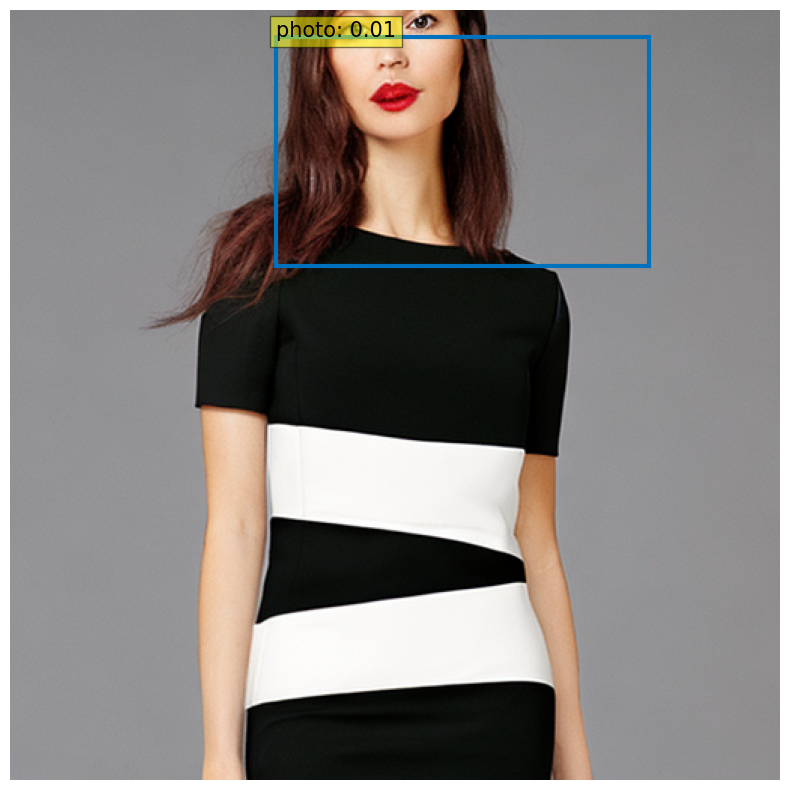

In [ ]:
plot_results(init_img, nms_results[0])